# Analising NiSi XRD data

In [73]:
import sys
print(sys.executable)

c:\Users\lhager\AppData\Local\Programs\Python\Python311\xrd_env\Scripts\python.exe


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True,                    # render text via LaTeX
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}"
})

### read file

In [75]:
file_path = r"../Data/XRD/02182026_Ni2Si_900grad_.xy"

data = pd.read_csv(file_path, delimiter=" ", skiprows=1, header=None, names=['Angle', 'Intensity'])

filename = os.path.basename(file_path)
name = filename.split("_", 1)[1].split("grad")[0]
print(name)

print(data.info())

Ni2Si_900
<class 'pandas.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Angle      3001 non-null   float64
 1   Intensity  3001 non-null   float64
dtypes: float64(2)
memory usage: 47.0 KB
None


### plot basic spectra starting point

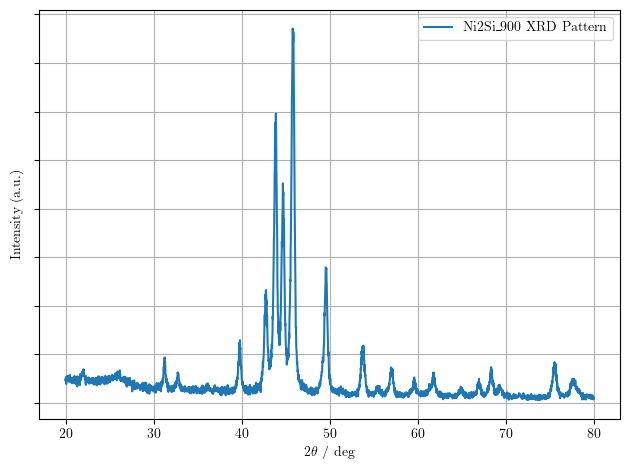

In [76]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['Intensity'], label=f'{name} XRD Pattern')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

## data processing
- remove background
- apply filter (Savitzky–Golay)
- normalise
- peak finding

In [77]:
# asymmetric least squares baseline correction
def baseline_als(y, lam=1e5, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2), dtype=None)
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w,0,L,L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

### baseline correction

In [78]:
baseline = baseline_als(data['Intensity'].values)
data['Intensity_corr'] = data['Intensity'] - baseline

C:\Users\lhager\AppData\Local\Temp\ipykernel_10564\4060365311.py:9: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



### filter

In [79]:
data['filtered'] = signal.savgol_filter(data['Intensity_corr'], window_length=11, polyorder=3)

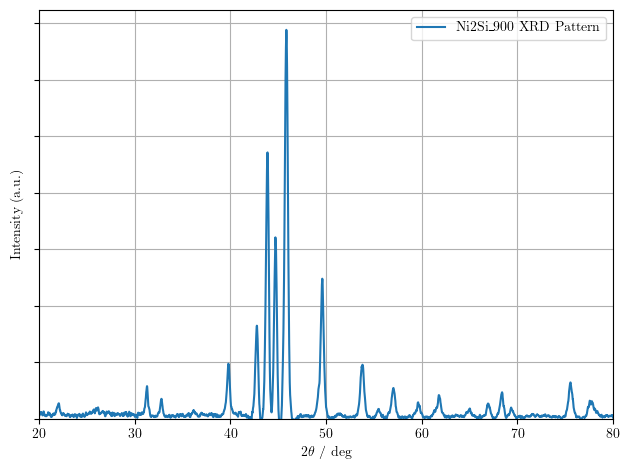

In [80]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['filtered'], label=f'{name} XRD Pattern')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=0)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

### normalise 

In [81]:
data['intensity_norm'] = data['filtered'] / data['filtered'].max()

### find peak position and height

In [82]:
# find peaks using scipy.signal.find_peaks
peaks, properties = signal.find_peaks(data['intensity_norm'], height=0.05, distance=10)
print("Peaks found at angles:", data['Angle'].iloc[peaks].values)

Peaks found at angles: [31.28 32.78 39.78 42.76 43.88 44.7  45.84 49.6  53.8  57.04 61.78 68.4
 75.54]


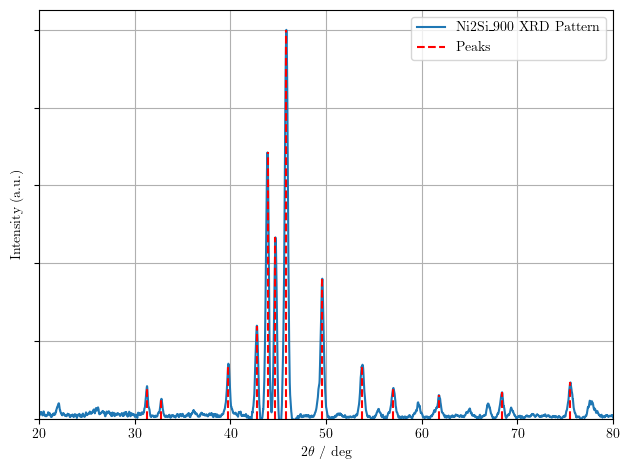

In [83]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['intensity_norm'], label=f'{name} XRD Pattern')

plt.vlines(data['Angle'].iloc[peaks].values, ymin=0, ymax=data['intensity_norm'].iloc[peaks], color='red', linestyle='--', label='Peaks')
ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=0)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

In [84]:
# add peak manually
new_id = data.index[data['Angle'] == 77.6].tolist()
peaks = np.append(peaks, new_id)  # add a peak at index 100 (example)
properties['peak_heights'] = np.append(properties['peak_heights'], data['intensity_norm'].iloc[new_id].values)  # add the height of the new peak
print("Peaks found at angles:", data['Angle'].iloc[peaks].values)

Peaks found at angles: [31.28 32.78 39.78 42.76 43.88 44.7  45.84 49.6  53.8  57.04 61.78 68.4
 75.54 77.6 ]


### lable peaks

In [97]:
NiSi2_peaks_index = [9, 12]
NiSi2_peaks = data['Angle'].iloc[peaks[NiSi2_peaks_index]].values
print(NiSi2_peaks)

NiSi_peaks_index = [0, 4, 5, 7, 8]
NiSi_peaks = data['Angle'].iloc[peaks[NiSi_peaks_index]].values
print(NiSi_peaks)

Ni2Si_peaks_index = [1, 2, 3, 6, 11]
Ni2Si_peaks = data['Angle'].iloc[peaks[Ni2Si_peaks_index]].values
print(Ni2Si_peaks)

Ni_peaks_index = [13]
Ni_peaks = data['Angle'].iloc[peaks[Ni_peaks_index]].values
print(Ni_peaks)

[57.04 75.54]
[31.28 43.88 44.7  49.6  53.8 ]
[32.78 39.78 42.76 45.84 68.4 ]
[77.6]


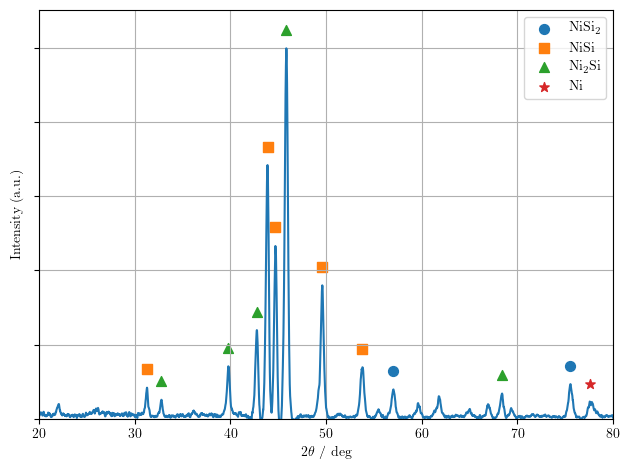

In [ ]:
markers = {
    'NiSi2': 'o',  # Circle
    'NiSi': 's',   # Square
    'Ni2Si': '^',  # Triangle
    'Ni': '*'      # Star
}

def mark_peaks(ax, angles, intensities, marker, label):
    # Offset the marker slightly above the peak for clarity
    offset = 0.05 
    ax.scatter(angles, intensities + offset, marker=marker, label=label, s=50)


fig, ax = plt.subplots()

ax.plot(data['Angle'], data['intensity_norm'])

# plt.vlines(data['Angle'].iloc[peaks].values, ymin=0, ymax=data['intensity_norm'].iloc[peaks], color='red', linestyle='--', label='Peaks')
mark_peaks(ax, NiSi2_peaks, data['intensity_norm'].iloc[peaks[NiSi2_peaks_index]], markers['NiSi2'], 'NiSi$_2$')
mark_peaks(ax, NiSi_peaks, data['intensity_norm'].iloc[peaks[NiSi_peaks_index]], markers['NiSi'], 'NiSi')
mark_peaks(ax, Ni2Si_peaks, data['intensity_norm'].iloc[peaks[Ni2Si_peaks_index]], markers['Ni2Si'], 'Ni$_2$Si')
mark_peaks(ax, Ni_peaks, data['intensity_norm'].iloc[peaks[Ni_peaks_index]], markers['Ni'], 'Ni')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=0)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/XRD/{name}.pdf', dpi=500)
plt.show()


In [99]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data['Angle'], 
    y=data['intensity_norm'],
    mode='lines',
    name=name,
    showlegend=False,
    line=dict(color='black', width=1)
))


phases = {
    'NiSi₂': {'indices': NiSi2_peaks_index, 'symbol': 'circle'},
    'NiSi':  {'indices': NiSi_peaks_index,  'symbol': 'square'},
    'Ni₂Si': {'indices': Ni2Si_peaks_index, 'symbol': 'triangle-up'},
    'Ni':    {'indices': Ni_peaks_index,    'symbol': 'star'}
}

# 3. Add markers for each phase
for phase, info in phases.items():
    # Extract X and Y values for these specific peaks
    peak_angles = data['Angle'].iloc[peaks[info['indices']]]
    peak_heights = data['intensity_norm'].iloc[peaks[info['indices']]]
    
    fig.add_trace(go.Scatter(
        x=peak_angles,
        y=peak_heights + 0.02, # Small vertical offset
        mode='markers',
        marker=dict(symbol=info['symbol'], size=10),
        name=phase
    ))


fig.update_layout(
    xaxis_title="2θ (degrees)",
    yaxis_title="Intensity (a.u.)",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()

|Phase|material_id|shape|  |   |   |   |   |   |  |  |  |  |  |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|$NiSi_2$|mp-2291   | Cubic | 28.68  |  47.72 | 56.63  | 69.78  | 77.12 |  |  |  |  |  |  |
|$NiSi$|mp-1095177  | Cubic | 27.77  |  34.46 | 40.00  | 44.97  | 49.54 | 61.74 | 65.48 | 69.12 | 76.15 | 79.58 |  |
|$NiSi$|mp-351      | Ortho | 31.33 | 34.87 | 35.97 | 44.53 | 46.01 | 47.57 | 52.35 | 56 | 76.29 | 79.6 |  |
|$Ni_2Si$|mp-1118   | Ortho | 27.25 | 32.85 | 39.87 | 42.83 | 44.12 | 45.94 | 49.25 | 54.07 | 68.86 | 76.14 | 78.78 |
|$NiSi_2$|mp-507    | hex   | 32.28 | 45.72 | 46.88 | 67.57 | 77.62 |  |  |  |  |  |  |
|$Ni$   |mp-23      | Cubic | 45.15 | 52.63 | 77.65 |  |  |  |  |  |  |  |  |
|$Ni$   |mp-10257   | hex   | 42.61 | 44.45 | 48.36 | 63.27 | 77.99 |  |  |  |  |  |  |

In [100]:
reference_phases = [
    {"phase": "NiSi2", "id": "mp-2291", "peaks": [28.68, 47.72, 56.63, 69.78, 77.12]},
    {"phase": "NiSi", "id": "mp-1095177", "peaks": [27.77, 34.46, 40.00, 44.97, 49.54, 61.74, 65.48, 69.12, 76.15, 79.58]},
    {"phase": "NiSi", "id": "mp-351", "peaks": [31.33, 34.87, 35.97, 44.53, 46.01, 47.57, 52.35, 56, 76.29, 79.6]},
    {"phase": "Ni2Si", "id": "mp-1118", "peaks": [27.25, 32.85, 39.87, 42.83, 44.12, 45.94, 49.25, 54.07, 68.86, 76.14, 78.78]},
    {"phase": "Ni2Si", "id": "mp-507", "peaks": [32.28, 45.72, 46.88, 67.57, 77.62]},
    {"phase": "Ni", "id": "mp-23", "peaks": [45.15, 52.63, 77.65]},
    {"phase": "Ni", "id": "mp-10257", "peaks": [42.61, 44.45, 48.36, 63.27, 77.99]},
]

# Your experimental peaks found via find_peaks
exp_peaks = data['Angle'].iloc[peaks].values 

tolerance = 0.2  # Degrees 2-theta
results = {}

for ref in reference_phases:
    matched_angles = []
    for p_ref in ref['peaks']:
        # Find if any experimental peak is within the tolerance of the reference peak
        diff = np.abs(exp_peaks - p_ref)
        if np.any(diff <= tolerance):
            # Get the actual experimental angle that matched
            best_match = exp_peaks[np.argmin(diff)]
            matched_angles.append(best_match)
    
    results[f"{ref['phase']}_{ref['id']}"] = matched_angles

print(results)

fig = go.Figure()

# Plot the raw data
fig.add_trace(go.Scatter(x=data['Angle'], y=data['intensity_norm'], name='Data', line=dict(color='black')))

# Define marker styles
styles = {'NiSi2': 'circle', 'NiSi': 'square', 'Ni2Si': 'triangle-up', 'Ni': 'star'}

for label, matched_peaks in results.items():
    if not matched_peaks: continue
    
    phase_name = label.split('_')[0]
    
    # Filter intensities for these specific matched peaks
    # We find the index in the original 'data' where the angle matches our matched_peaks
    y_vals = data.set_index('Angle').loc[matched_peaks]['intensity_norm']
    
    fig.add_trace(go.Scatter(
        x=matched_peaks,
        y=y_vals + 0.05, # Offset for visibility
        mode='markers',
        marker=dict(symbol=styles.get(phase_name, 'cross'), size=10),
        name=label
    ))

fig.show()

{'NiSi2_mp-2291': [], 'NiSi_mp-1095177': [np.float64(49.6), np.float64(61.78)], 'NiSi_mp-351': [np.float64(31.28), np.float64(44.7), np.float64(45.84)], 'Ni2Si_mp-1118': [np.float64(32.78), np.float64(39.78), np.float64(42.76), np.float64(45.84)], 'Ni2Si_mp-507': [np.float64(45.84), np.float64(77.6)], 'Ni_mp-23': [np.float64(77.6)], 'Ni_mp-10257': [np.float64(42.76)]}
